In [2]:
import sys
sys.path.append("..")
import splitwavepy as s

# import scipy
# import numpy as np
# import matplotlib.pyplot as plt

ImportError: cannot import name plotting

# Lam1/Lam2 versus Lam1 and Lam2 surfaces

Tests on synthetics clearly demonstrate that lam1/lam2 is superior to using the lam2 surface.

The reason everyone has used the lam2 surfaces seems to go back to Silver and Chan (1991) who claim that using min lam2, max lam1, max lam1/lam2, or min lam1 * lam2 is equivalent.  Further, using lam2 facilitates the use of an F-test to calculate a confidence contour to a desired level (e.g. 95%).

Playing around with synthetic clearly demonstrates the superiority of lam1/lam2 in returning the splitting parameters.

Another possible advantage of the lam1/lam2 surface is that it is self-normalising.  Lam1/Lam2 is independent of trace amplitudes, only depending on the relative amplitudes of the traces.  Furthermore, it is naturally scaled by the signal to noise ratio.  (Indeed, the maximum lam1/lam2 within the search window *is* the signal to noise ratio.)  Therefore, stacking of these surfaces naturally accounts for noisy measurements - a very nice property!

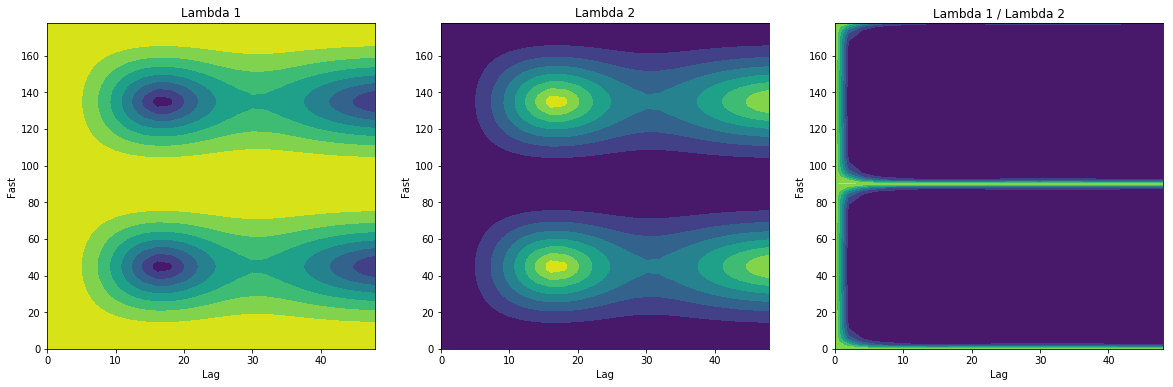

In [532]:

fast = 30
lag = 0

M = s.eigval.grideigval(s.split(s.synth(noise=0.001),fast,lag))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
ax[0].contourf(M.lags,M.degs,M.lam1,cmap='viridis')
ax[1].contourf(M.lags,M.degs,M.lam2,cmap='viridis')
ax[2].contourf(M.lags,M.degs,M.lam1/M.lam2,cmap='viridis')
ax[0].set_title('Lambda 1')
ax[1].set_title('Lambda 2')
ax[2].set_title('Lambda 1 / Lambda 2')
ax[0].set_xlabel('Lag')
ax[1].set_xlabel('Lag')
ax[2].set_xlabel('Lag')
ax[0].set_ylabel('Fast')
ax[1].set_ylabel('Fast')
ax[2].set_ylabel('Fast')
# plt.colorbar(ax)
plt.show()

# Summarising the result -- axis squashing

It is desirable to reduce a measurement from an error surface down to a couple of numbers accompanied by some errors.  These are easier to handle.

A method to do this using lambda 2 is well known, however, I think we should be using lambda1 / lambda2.  Can we do anything with these surfaces?

The approach I suggest is to sum the error surfaces along each of the axes, to "squash" the surface into two profiles, one for fast and one for lag.

We do this for the lam1/lam2, the lam1 surface, and the lam2 surface.  Clearly the result is best defined for the lam1/lam2 surface.

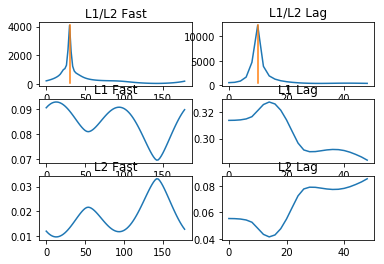

Lam1/Lam2: fast, lag: 30 10
Lam1: fast, lag: 12 14
Lam2: fast, lag: 12 14


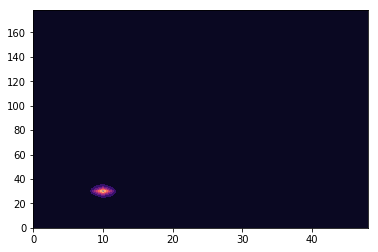

SNR 3630.4746332
Lam1/Lam2 max: fast, lag: 30 10


In [533]:
# splitting parameters
fast = 30
lag = 10
# sigma noise amplitude
noise = 0.001

M = s.eigval.grideigval(s.split(s.synth(noise=noise),fast,lag))

squashfast = np.sum(M.lam1/M.lam2, axis=0)
squashlag = np.sum(M.lam1/M.lam2, axis=1)
sfl1 = np.sum(M.lam1, axis=0)
sll1 = np.sum(M.lam1, axis=1)
sfl2 = np.sum(M.lam2, axis=0)
sll2 = np.sum(M.lam2, axis=1)

fig, ax = plt.subplots(nrows=3,ncols=2)

ax[0][0].plot(M.degs[0,:],squashfast)
ax[0][0].set_title('L1/L2 Fast')
ax[0][1].plot(M.lags[:,0],squashlag)
ax[0][1].set_title('L1/L2 Lag')

ax[1][0].plot(M.degs[0,:],sfl1)
ax[1][0].set_title('L1 Fast')
ax[1][1].plot(M.lags[:,0],sll1)
ax[1][1].set_title('L1 Lag')

ax[2][0].plot(M.degs[0,:],sfl2)
ax[2][0].set_title('L2 Fast')
ax[2][1].plot(M.lags[:,0],sll2)
ax[2][1].set_title('L2 Lag')

fastidx = np.where(M.degs[0,:]==fast)[0]
lagidx = np.where(M.lags[:,0]==lag)[0]

ax[0][0].plot([fast,fast],[np.min(squashfast),np.max(squashfast)])
ax[0][1].plot([lag,lag],[np.min(squashlag),np.max(squashlag)])

plt.show()

print('Lam1/Lam2: fast, lag:',M.degs[0,np.argmax(squashfast)],M.lags[np.argmax(squashlag),0])
print('Lam1: fast, lag:',M.degs[0,np.argmax(sfl1)],M.lags[np.argmax(sll1),0])
print('Lam2: fast, lag:',M.degs[0,np.argmin(sfl2)],M.lags[np.argmin(sll2),0])

M.plot()

print('SNR',M.snr)
print('Lam1/Lam2 max: fast, lag:',M.fast,M.lag)

# Use areas under squashed curves for error estimation

The plots show the summary measurements with orange lines marking the alpha level.  Alpha level of 0.05 corresponds to 95% of area below the curve where it is above this line.  Alpha level of 0.318 corresponds to 68.2% area below the curve above this line, this happens to be the area within one standard deviation of a gaussian normal distribution.

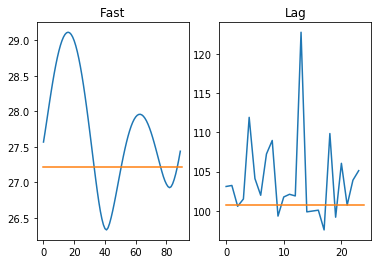

In [554]:
from scipy.interpolate import interp1d

def val_at_alpha(data,alpha):
    """
    Find value of function at the alpha level
    """
    idx = np.argsort(data)
    cum = np.cumsum(data[idx])
    tot = np.max(cum)
    get_x_at_cum = interp1d(cum, np.arange(cum.size))
    get_val_at_x = interp1d(np.arange(data.size), data[idx])
    xval = get_x_at_cum(tot*alpha)
    return get_val_at_x(xval)

# alpha = 0.318 corresponds to one sigma error bar assuming Gaussian distribution
v_fast = val_at_alpha(squashfast,.318)
v_lag = val_at_alpha(squashlag,.318)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(squashfast)
ax[0].plot([0,squashfast.size],[v_fast,v_fast])
ax[0].set_title('Fast')
ax[1].plot(squashlag)
ax[1].plot([0,squashlag.size],[v_lag,v_lag])
ax[1].set_title('Lag')

plt.show()

In [ ]:
# Associated error bars


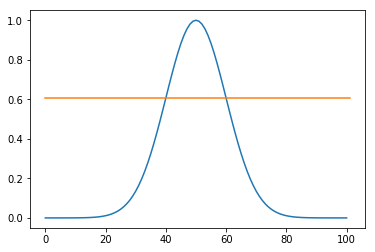

In [560]:
# Test on a well known function (Gaussian)

from scipy import signal
a = signal.gaussian(101,10)
y = val_at_alpha(a,0.318)

plt.plot(a)
plt.plot([0,a.size],[y,y])
plt.show()

# Automated Null classification

We can use the property of self-similarity in null error surfaces at 90 degrees rotation to automatically detect null measurements.

The approach developed here is to shift the squashed fast profile by 90 degrees.  If this is a perfect null measurement this shifted trace will be very similar to the original trace.  The result of multiplying, sample by sample, the two traces will be maximised; the result of subtracting one trace from the other will be minimised.  We call these two traces mult and diff. The ratio diff / mult will be small and tend to zero for null measurements.

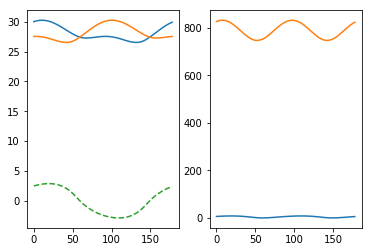

sumdiff =  176.433269052
sumdiffsq =  410.735024295
summult =  71165.5945451
ratio diff2_mult =  0.00577153927991
ratio mult_diff2 =  173.264003155


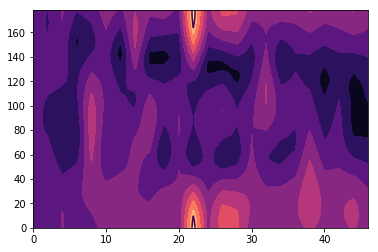

NI =  0.00577153927991
SNR =  1.60884242753


In [555]:
lag = 30
fast = 30
M = s.eigval.grideigval(s.split(s.synth(noise=1),fast,lag))

squashfast = np.sum(M.lam1/M.lam2, axis=0)
squashlag = np.sum(M.lam1/M.lam2, axis=1)
sfl1 = np.sum(M.lam1, axis=0)
sll1 = np.sum(M.lam1, axis=1)
sfl2 = np.sum(M.lam2, axis=0)
sll2 = np.sum(M.lam2, axis=1)
diff = squashfast - np.roll(squashfast,45)
mult = squashfast * np.roll(squashfast,45)

fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].plot(M.degs[0,:],squashfast)
ax[0].plot(M.degs[0,:],np.roll(squashfast,45))
ax[0].plot(M.degs[0,:],diff,'--')
ax[1].plot(M.degs[0,:],diff**2)
ax[1].plot(M.degs[0,:],mult)
# ax[1].plot(M.degs[0,:],diff**2/mult)
# ax1.plot(M.degs[0,:],mult,'--')
plt.show()

sumdiff = np.sum(np.abs(diff))
sumdiffsq = np.sum(diff**2)
summult = np.sum(mult)
print('sumdiff = ',sumdiff)
print('sumdiffsq = ', sumdiffsq)
print('summult = ',summult)
print('ratio diff2_mult = ',sumdiffsq/summult)
print('ratio mult_diff2 = ',summult/sumdiffsq)

def NI(M):
    squashfast = np.sum(M.lam1/M.lam2, axis=0)
    squashlag = np.sum(M.lam1/M.lam2, axis=1)
    diff = squashfast - np.roll(squashfast,45)
    mult = squashfast * np.roll(squashfast,45)
    sumdiffsq = np.sum(diff**2)
    summult = np.sum(mult)
    return sumdiffsq/summult

M.plot()
print('NI = ',NI(M))
print('SNR = ',M.snr)

# Polar Error Surfaces

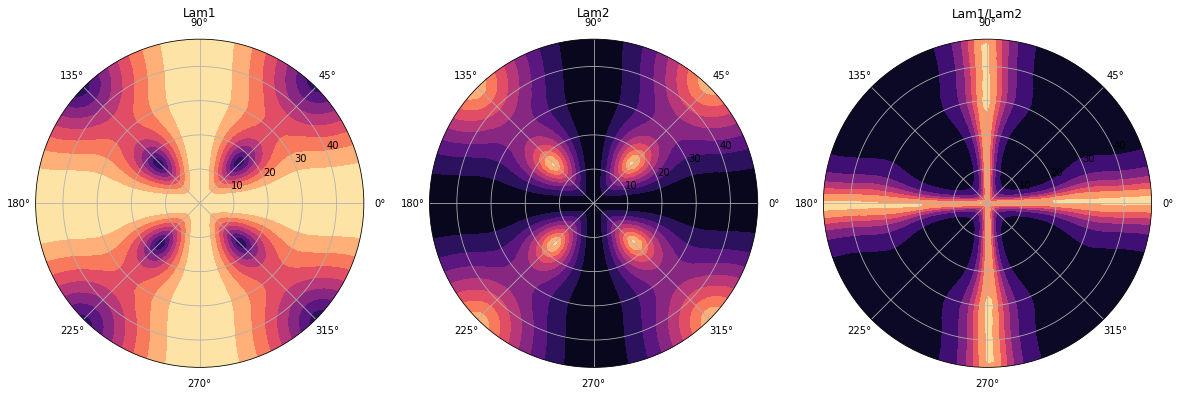

In [577]:
lag = 0
fast = 45
M = s.eigval.grideigval(s.split(s.synth(noise=.01),fast,lag))

rads = np.deg2rad(np.column_stack((M.degs,M.degs+180,M.degs[:,0]+360)))
lags = np.column_stack((M.lags,M.lags,M.lags[:,0]))
lam1 = np.column_stack((M.lam1,M.lam1,M.lam1[:,0]))
lam2 = np.column_stack((M.lam2,M.lam2,M.lam2[:,0]))                  


fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),nrows=1,ncols=3,figsize=(20,8))
ax[0].contourf(rads,lags,lam1,cmap='magma')
ax[0].set_title('Lam1')
ax[1].contourf(rads,lags,lam2,cmap='magma')
ax[1].set_title('Lam2')
ax[2].contourf(rads,lags,lam1/lam2,cmap='magma')
ax[2].set_title('Lam1/Lam2')
plt.show()